In [1]:
# Підключаємо бібліотеки
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
from pathlib import Path
from PIL import Image
import imageio
import os
import time

In [2]:
# Глобальні налаштування
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
z_dim = 100
batch_size = 128
num_epochs = 1000
sample_interval = 10
sample_dir = Path('progan_samples')
models_dir = Path('progan_models')
sample_dir.mkdir(exist_ok=True)
models_dir.mkdir(exist_ok=True)
gif_path = 'progan_progress.gif'

In [3]:
# Модель Генератора
class ProGANGenerator(nn.Module):
    def __init__(self, z_dim):
        super().__init__()
        self.init_size = 7
        self.l1 = nn.Linear(z_dim, 128 * self.init_size * self.init_size)
        
        self.upsample_blocks = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
        )
        
        self.final_block = nn.Sequential(
            nn.Conv2d(64, 1, 3, stride=1, padding=1),
            nn.Tanh()
        )
    
    def forward(self, z):
        out = self.l1(z)
        out = out.view(out.size(0), 128, self.init_size, self.init_size)
        out = self.upsample_blocks(out)
        out = F.interpolate(out, scale_factor=2)
        img = self.final_block(out)
        return img

In [4]:
# Модель Дискримінатора
class ProGANDiscriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.downsample_blocks = nn.Sequential(
            nn.Conv2d(1, 64, 3, stride=1, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.AvgPool2d(2),  # 28 -> 14

            nn.Conv2d(64, 128, 3, stride=1, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.AvgPool2d(2),  # 14 -> 7
        )
        
        self.final_block = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 7 * 7, 1)
        )
    
    def forward(self, img):
        out = self.downsample_blocks(img)
        validity = self.final_block(out)
        return validity

In [5]:
# Завантаження датасету MNIST
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # [-1, 1]
])

dataset = datasets.MNIST(root='.', train=True, transform=transform, download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [6]:
# Ініціалізація моделей
generator = ProGANGenerator(z_dim).to(device)
discriminator = ProGANDiscriminator().to(device)


In [7]:
# Оптимізатори та функція втрат
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
loss_fn = nn.BCEWithLogitsLoss()


In [8]:
# Фіксоване тестове шумове test_z
test_z = torch.randn(16, z_dim, device=device)

# Функція збереження прикладів
def save_samples(generator, epoch):
    generator.eval()
    with torch.no_grad():
        fake_images = generator(test_z).cpu()
        grid = make_grid(fake_images, nrow=4, normalize=True, value_range=(-1, 1))
        save_image(grid, sample_dir / f"{epoch}.png")
    generator.train()

In [9]:
# Функція збереження моделі
def save_models(generator, discriminator, epoch):
    torch.save(generator.state_dict(), models_dir / f"generator_epoch_{epoch}.pth")
    torch.save(discriminator.state_dict(), models_dir / f"discriminator_epoch_{epoch}.pth")


In [10]:
# Основний цикл навчання
start = time.time()

for epoch in range(num_epochs):
    for real_imgs, _ in dataloader:
        real_imgs = real_imgs.to(device)
        batch_size_curr = real_imgs.size(0)

        # Тренування Дискримінатора
        z = torch.randn(batch_size_curr, z_dim, device=device)
        fake_imgs = generator(z).detach()

        real_labels = torch.ones(batch_size_curr, 1, device=device)
        fake_labels = torch.zeros(batch_size_curr, 1, device=device)

        real_loss = loss_fn(discriminator(real_imgs), real_labels)
        fake_loss = loss_fn(discriminator(fake_imgs), fake_labels)
        d_loss = (real_loss + fake_loss) / 2

        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()

        # Тренування Генератора
        z = torch.randn(batch_size_curr, z_dim, device=device)
        fake_imgs = generator(z)

        g_loss = loss_fn(discriminator(fake_imgs), real_labels)

        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()

    

    # Зберігаємо тільки кожні sample_interval епох
    if epoch % sample_interval == 0 or epoch == 0:
        print(f"Epoch [{epoch}/{num_epochs}] | D_loss: {d_loss.item():.4f} | G_loss: {g_loss.item():.4f}")
        save_samples(generator, epoch)
        save_models(generator, discriminator, epoch)
    
timer = time.time()-start
print ('Time for epochs {} is {} min'.format(num_epochs, int(timer/60)))

Epoch [0/1000] | D_loss: 0.7060 | G_loss: 0.7521
Epoch [10/1000] | D_loss: 0.7457 | G_loss: 1.2654
Epoch [20/1000] | D_loss: 0.5991 | G_loss: 0.7736
Epoch [30/1000] | D_loss: 0.6363 | G_loss: 0.9482
Epoch [40/1000] | D_loss: 0.6473 | G_loss: 0.8891
Epoch [50/1000] | D_loss: 0.6531 | G_loss: 0.5794
Epoch [60/1000] | D_loss: 0.6618 | G_loss: 0.6073
Epoch [70/1000] | D_loss: 0.6425 | G_loss: 0.7713
Epoch [80/1000] | D_loss: 0.6231 | G_loss: 0.7319
Epoch [90/1000] | D_loss: 0.6448 | G_loss: 0.8965
Epoch [100/1000] | D_loss: 0.6508 | G_loss: 0.7011
Epoch [110/1000] | D_loss: 0.6066 | G_loss: 0.8521
Epoch [120/1000] | D_loss: 0.6015 | G_loss: 0.8091
Epoch [130/1000] | D_loss: 0.5812 | G_loss: 0.8861
Epoch [140/1000] | D_loss: 0.6337 | G_loss: 0.5397
Epoch [150/1000] | D_loss: 0.6144 | G_loss: 0.6921
Epoch [160/1000] | D_loss: 0.5715 | G_loss: 0.8754
Epoch [170/1000] | D_loss: 0.5921 | G_loss: 0.8967
Epoch [180/1000] | D_loss: 0.6438 | G_loss: 1.3186
Epoch [190/1000] | D_loss: 0.6131 | G_loss

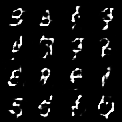

In [11]:
import os
import glob
import imageio
import numpy as np
import IPython.display as display

# Зчитуємо всі збережені картинки
imgs = sorted(
    glob.glob('progan_samples/*.png'),
    key=lambda x: int(os.path.splitext(os.path.basename(x))[0])
)

frames = []

# Кількість проміжних кадрів між 2 основними
transition_frames = 5

for idx in range(len(imgs)-1):
    img1 = imageio.v3.imread(imgs[idx]).astype(np.float32) / 255.0
    img2 = imageio.v3.imread(imgs[idx+1]).astype(np.float32) / 255.0
    
    # Додаємо початковий кадр
    frames.append((img1 * 255).astype(np.uint8))
    
    # Плавні переходи між img1 і img2
    for t in range(1, transition_frames):
        alpha = t / transition_frames
        blended = (1 - alpha) * img1 + alpha * img2
        frames.append((blended * 255).astype(np.uint8))

# Додаємо останній кадр
last_img = imageio.v3.imread(imgs[-1])
frames.append(last_img)

# Зберігаємо фінальний плавний GIF
imageio.mimsave(gif_path, frames, duration=0.1)

# Показати в ноутбуці
display.Image(filename=gif_path)